# Inferring Stem Cell Dynamics From the Shape of a Single Cell Genealogy

##### Dhriti Krishna Rao, supervised by Dr. Aylwyn Scally


## Methods

### The cell proliferation model

In [1]:
from numpy.random import random
import numpy as np
import argparse
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import pandas as pd
from ete3 import Tree
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import openpyxl
from sklearn.neighbors import KernelDensity
import seaborn as sns
from scipy.interpolate import interp1d

p = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
p.add_argument('-v', '--verbose', action='store_true', default = False)
p.add_argument('--pGS', type = float, default = 0.01, help = 'PGC specification probability')
p.add_argument('--pdeath', type = float, default = 0.1, help = 'cell death probability')
p.add_argument('--GScycles', default = '2, 4', help = 'PGC specification cycles: start,end')
p.add_argument('--tc', type = float, default = 0.5, help = 'cycle time (d)')
p.add_argument('--start_day', type = float, default = 0.0, help = 'initial time (d)')
p.add_argument('--start_reps', type = int, default = 0, help = 'initial reps (from zygote)')
p.add_argument('--max_reps_follow', type = int, default = 6, help = 'max reps to follow')
p.add_argument('-n', '--nclones', type = int, default = 500, help = 'number of clones to simulate')
args = p.parse_args(args=[])


(GS_start, GS_end) = [int(x) for x in args.GScycles.split(',')]

def cbranch(clone, ctype, time, reps, branch, graph):
    if random() < args.pdeath:  #simulation of clone ends if cell dies
        return (graph)
    time += args.tc
    reps += 1
    if ctype == 'S' and reps >= GS_start and reps <= GS_end: # test for germline specification
        if random() < args.pGS:
            ctype = 'G'
    if ctype == 'S' and reps >= GS_end: # don't follow somatic lineages after germline specification
        return (graph)
    if reps >= args.max_reps_follow:
        return (graph)
    graph.add_edge(branch, branch+'1')
    graph.add_edge(branch, branch+'0')
    graph = cbranch(clone, ctype, time, reps, branch + '1', graph)
    graph = cbranch(clone, ctype, time, reps, branch + '0', graph)

    return(graph)

def visualise_nx(tree):
    pos = nx.nx_agraph.graphviz_layout(tree, prog="dot")
    nx.draw(tree, pos, with_labels=True)
    plt.savefig(str(tree)+'.png')
    plt.show()
    return

### Index calculations


In [2]:
# Colless Index
def colless(tree):
    colless = 0
    for i in tree.nodes:
        if tree.out_degree(i) == 0: #skip leaves
            continue
        else:
            nl = []
            for j in tree.neighbors(i):
                subtree = dfs_tree(tree, j) # create subtree rooted at j
                num=0
                for k in subtree.nodes:
                    if subtree.out_degree(k) == 0:
                        num+=1
                nl.append(num)
            diff = abs(nl[0] - nl[1])
        colless+= diff
    return(colless)

#Lemant et al, J1
def S_i(tree, i):
    subtree = dfs_tree(tree, i)
    fv = 0
    for v in subtree.nodes:
        fv+=1
    return(fv)
def S_star_i (tree, i):
    Si = S_i(tree, i)
    return (Si-1)

def W_i(tree, i):
    Si = S_star_i(tree, i)
    Wij = 0
    if tree.out_degree(i)==0:
        return(0)
    for j in tree.neighbors(i):
        pij = S_i (tree, j)/Si
        Wij+= -1*pij*np.log2(pij) #outdegree of all internal nodes is 2, so log base 2 is used
    return(Wij)
def J1(tree):
    num = 0
    denom = 0
    for k in tree.nodes:
        if tree.out_degree(k)==0: #skip leaves
            continue
        else:
            Sk = S_star_i(tree, k)
            Wi = W_i(tree, k)
            num+= Sk*Wi
            denom += Sk
    if denom == 0:
        return(np.nan)
    else:
        return (num/denom)

## Results
### Characterising the indices
#### Relationship to death rate

death rate is  0.0
death rate is  0.1
death rate is  0.2
death rate is  0.4
death rate is  0.8


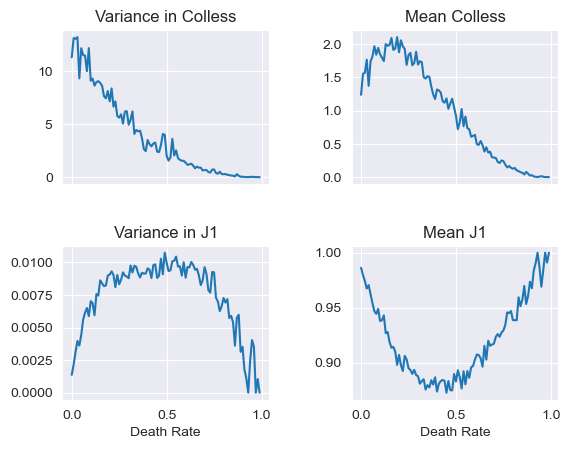

In [3]:
#simulate 500 clones at each death rate
#calculate index value for each clone
#calculate and store mean and variance in inidices for each death rate
deathRates = np.arange(0,1, 0.01)
indices = pd.DataFrame(
    {"death rate": deathRates,
     "meanColless": np.zeros(100),
     "varColless": np.zeros(100),
     "meanJ1": np.zeros(100),
     "varJ1": np.zeros(100)
     }
)
for j in deathRates:
    args.pdeath = j
    if j % 0.1 == 0:
        print("death rate is ", j)
    collessIndex = []
    lemIndex = []
    for i in range(args.nclones):
        tree = nx.DiGraph()
        if args.verbose:
            print('clone %d' % (i))
        tree = cbranch(i, 'S', args.start_day, args.start_reps, '0', tree)
        collessIndex.append(colless(tree))
        lemIndex.append(J1(tree))
    collessIndex = np.array(collessIndex)
    lemIndex = np.array(lemIndex)
    indices.loc[indices["death rate"]==args.pdeath, ["meanColless"]] = np.nanmean(collessIndex)
    indices.loc[indices["death rate"]==args.pdeath, ["varColless"]] = np.nanvar(collessIndex)
    indices.loc[indices["death rate"]==args.pdeath, ["meanJ1"]] = np.nanmean(lemIndex)
    indices.loc[indices["death rate"]==args.pdeath, ["varJ1"]] = np.nanvar(lemIndex)
    collessIndex = collessIndex.tolist()
    lemIndex = lemIndex.tolist()

fig, axs = plt.subplots(2,2, sharex=True)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
axs[1,1].set_title("Mean J1")
axs[1,0].set_title("Variance in J1")
axs[0,1].set_title("Mean Colless")
axs[0,0].set_title("Variance in Colless")
axs[1,0].set_xlabel("Death Rate")
axs[1,1].set_xlabel("Death Rate")
axs[0,0].plot(indices["death rate"], indices["varColless"])
axs[0,1].plot(indices["death rate"], indices["meanColless"])
axs[1,0].plot(indices["death rate"], indices["varJ1"])
axs[1,1].plot(indices["death rate"], indices["meanJ1"])
plt.savefig('initial_plots.png')
plt.show()

#### Introducing the sampling problem

The next step was to see how much these index values changed when they were calculated from a tree that was reconstructed from a subset of the leaves, instead of the simulated tree itself. To do this, first we simulated 500 trees at death rate = 0.1, and calculated the indices based on a range of sampling proportions. This appears to have a greater impact on the Colless index than on the J1, but it is difficult to compare since they act on quite different scales (J1 is restricted to values between 0 and 1, while Colless can be any integer greater than or equal to zero).

In [4]:
#functions to convert between networkx and newick/ete3
def nx_to_nw(root, graph):
    newick = ''
    a, b = graph.neighbors(root)
    if graph.out_degree(a) == 0:
        newick += '('+str(a)+','
    else:
        newick += '('+nx_to_nw(a, graph)+','
    if graph.out_degree(b) == 0:
        newick += str(b)+')'+str(root)
    else:
        newick += nx_to_nw(b, graph)+')'+str(root)
    return newick
def nw_to_ete3(root, graph):
    newickString = nx_to_nw(root, graph)
    newickString+=';'
    t = Tree(newickString, format = 8)
    return(t)
def ete3_to_nx(eteTree):
    nxTree = nx.DiGraph()
    root = eteTree.get_tree_root()
    nxTree.add_node(root.name)
    for node in eteTree.traverse("levelorder"):
        if len(node.children) == 0:
            continue
        else:
            for j in node.children:
                nxTree.add_edge(node.name, j.name)
    return nxTree

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100%


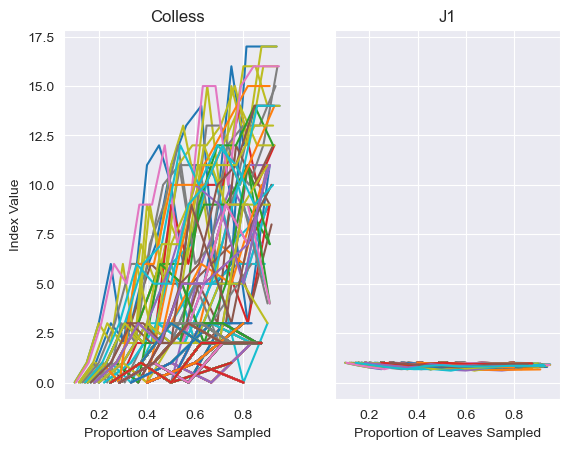

In [5]:
clones = []
leafP = []
colless_indices = []
lemant_indices = []
args.pdeath = 0.1
for i in range(args.nclones):
    if ((i/args.nclones)*100)%10 == 0:
        print ((i/args.nclones)*100, '%')
    tree = nx.DiGraph()
    if args.verbose:
        print('clone %d' % (i))
    tree = cbranch(i, 'S', args.start_day, args.start_reps, '0', tree)
    if len(tree.nodes) == 0:
        continue
    eteTree = nw_to_ete3('0', tree)
    leafList = eteTree.get_leaves()
    leaves = [str(j.name) for j in leafList]
    for p in range(2,len(leaves)):
        sampleLeaves = np.random.choice(leaves, p, replace = False).tolist()
        copy = nw_to_ete3('0', tree)
        copy.prune(sampleLeaves)
        prunedTree = ete3_to_nx(copy)
        clones.append(i)
        leafP.append(p/len(leaves))
        colless_indices.append(colless(prunedTree))
        lemant_indices.append(J1(prunedTree))
print('100%')
indices_leaves = pd.DataFrame(
    {"clone": clones,
     "proportion of leaves sampled": leafP,
     "colless": colless_indices,
     "J1": lemant_indices
     }
)
fig, axs = plt.subplots(1,2, sharey=True)
axs[0].set_title("Colless")
axs[1].set_title("J1")
axs[0].set_xlabel("Proportion of Leaves Sampled")
axs[1].set_xlabel("Proportion of Leaves Sampled")
axs[0].set_ylabel("Index Value")
for i in range(args.nclones):
    axs[0].plot(indices_leaves.loc[indices_leaves['clone'] == i, ['proportion of leaves sampled']], indices_leaves.loc[indices_leaves['clone'] == i, ['colless']])
    axs[1].plot(indices_leaves.loc[indices_leaves['clone'] == i, ['proportion of leaves sampled']], indices_leaves.loc[indices_leaves['clone'] == i, ['J1']])
plt.show()

To try and produce a fairer comparison of the noise introduced by only sampling a subset of the leaves, the standard deviation in the indices calculated at a given proportion was divided by the average of those indices. This produced the following plot, which shows that only the Colless index ever had sampling proportions where the noise was greater than the signal.

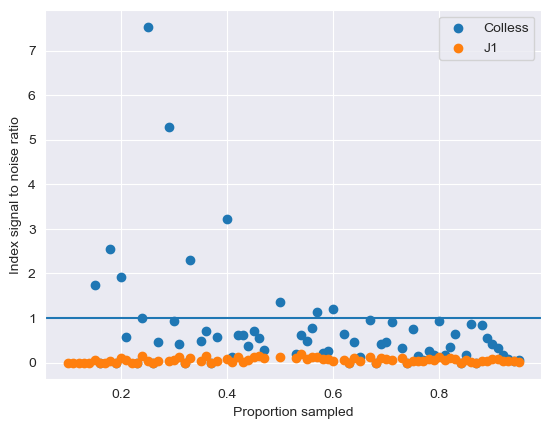

In [6]:
indices_leaves['rounded proportions'] = indices_leaves['proportion of leaves sampled'].round(2)
stdevData = pd.DataFrame({'proportion of leaves sampled':[],'standard deviation of colless':[], 'standard deviation of J1':[]})
proportions = []
stdevJ = []
stdevC = []
avgJ = []
avgC = []
for i in indices_leaves['rounded proportions'].unique():
    proportions.append(i)
    stdevJ.append(indices_leaves.loc[indices_leaves['rounded proportions'] == i, ['J1']].to_numpy().std())
    avgJ.append(np.nanmean(indices_leaves.loc[indices_leaves['rounded proportions'] == i, ['J1']].to_numpy()))
    stdevC.append(indices_leaves.loc[indices_leaves['rounded proportions'] == i, ['colless']].to_numpy().std())
    avgC.append(np.nanmean(indices_leaves.loc[indices_leaves['rounded proportions'] == i, ['colless']].to_numpy()))
stdevData = pd.DataFrame({'proportion of leaves sampled':proportions,'average colless index': avgC, 'standard deviation of colless':stdevC, 'average J1 index': avgJ, 'standard deviation of J1':stdevJ})
stdevData['colless signal to noise'] = stdevData['standard deviation of colless']/stdevData['average colless index']
stdevData['J1 signal to noise'] = stdevData['standard deviation of J1']/stdevData['average J1 index']
plt.scatter(stdevData['proportion of leaves sampled'], stdevData['colless signal to noise'], label = 'Colless')
plt.scatter(stdevData['proportion of leaves sampled'], stdevData['J1 signal to noise'], label = 'J1')
plt.axhline(y=1)
plt.xlabel('Proportion sampled')
plt.ylabel('Index signal to noise ratio')
plt.legend()
plt.show()


Another method we looked at to characterise noise was to look at it across death rates. For this, we simulated one clone at each death rate. Then, for each clone we calculated the index for a range of sampling proportions and calculated the standard deviation across these. Once this had been done for all the death rates, the standard deviation for each was divided by the range of actual index values across the death rates. This noise:signal ratio was then plotted against the death rate. Interestingly, both the Colless and the J1 index showed noise/signal consistently <1 across all death rates.

death rate is  0.0
death rate is  0.1
No Tree
death rate is  0.2
No Tree
No Tree
No Tree
No Tree
No Tree
No Tree
No Tree
death rate is  0.4
No Tree
No Tree
No Tree


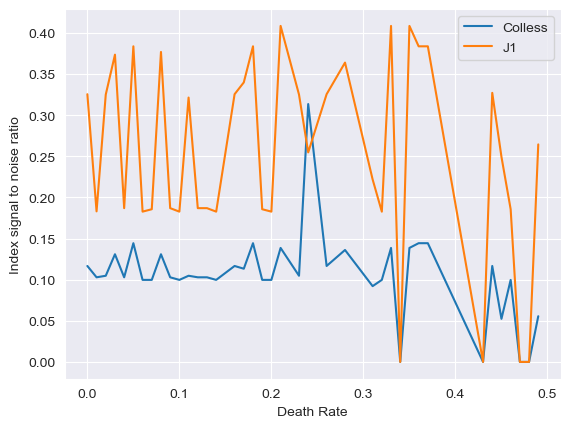

In [7]:
deathRates = np.arange(0,0.5, 0.01)
standardDevCol = []
colVal = []
standardDevLem = []
lemVal = []
deathRate = []
for i in deathRates:
    args.pdeath = i
    if i % 0.1 == 0:
        print("death rate is ", i)
    c = []
    j = []
    tree = nx.DiGraph()
    tree = cbranch(0, 'S', args.start_day, args.start_reps, '0', tree)
    c.append(colless(tree))
    j.append(J1(tree))
    if len(tree.nodes) == 0:
        print("No Tree")
        continue
    else:
        colVal.append(colless(tree))
        lemVal.append(J1(tree))
        eteTree = nw_to_ete3('0', tree)
        leafList = eteTree.get_leaves()
        leaves = [str(k.name) for k in leafList]
        for p in range(2,len(leaves)):
            sampleLeaves = np.random.choice(leaves, p, replace = False).tolist()
            copy = nw_to_ete3('0', tree)
            copy.prune(sampleLeaves)
            prunedTree = ete3_to_nx(copy)
            c.append(colless(prunedTree))
            j.append(J1(prunedTree))
        c = np.array(c)
        j = np.array(j)
        deathRate.append(i)
        standardDevCol.append(np.nanstd(c))
        standardDevLem.append(np.nanstd(j))
    c = c.tolist()
    j = j.tolist()
stdData = pd.DataFrame({'Death Rate':deathRate, 'Actual Colless Value': colVal, 'Standard Deviation in Colless': standardDevCol, 'Actual J1 Value':lemVal,'Standard Deviation in J1':standardDevLem})
colRange = np.nanmax(stdData['Actual Colless Value'].to_numpy()) - np.nanmin(stdData['Actual Colless Value'].to_numpy())
lemRange = np.nanmax(stdData['Actual J1 Value'].to_numpy()) - np.nanmin(stdData['Actual J1 Value'].to_numpy())
stdData['Colless signal to noise'] = stdData['Standard Deviation in Colless']/colRange
stdData['J1 signal to noise'] = stdData['Standard Deviation in J1']/lemRange
plt.plot(stdData['Death Rate'], stdData['Colless signal to noise'], label = 'Colless')
plt.plot(stdData['Death Rate'], stdData['J1 signal to noise'], label = 'J1')
plt.xlabel('Death Rate')
plt.ylabel('Index signal to noise ratio')
plt.legend()
plt.show()

For a more quantitative measure of the relationship of the indices with death rate and sampling proportions, an ANOVA test was performed as below. In this, it was seen that both the Colless and the J1 indices varied significantly with both death rate and sampling proportion. Limiting the dataset to exclude death rates above 0.3 and sampling proportions below 0.8 resulted in J1 no longer varying significantly with sampling proportion, while Colless still does. This suggests that J1 is somewhat more robust to the sampling issue. However, such ANOVA tests rely on performing a linear regression on the data, which may not be a very good approximation of their behaviour - especially for the Colless index.

In [8]:
col = []
lem = []
prop = []
death = []



resdeathRates = np.arange(0,0.5, 0.01)

for j in resdeathRates:
    args.pdeath = j
    if j % 0.1 == 0:
        print("death rate is ", j)
    for i in range(args.nclones):
        #if ((i/args.nclones)*100)%10 == 0:
            #print ((i/args.nclones)*100, '%')
        tree = nx.DiGraph()
        #if args.verbose:
            #print('clone %d' % (i))
        tree = cbranch(i, 'S', args.start_day, args.start_reps, '0', tree)
        if len(tree.nodes) == 0:
            continue
        eteTree = nw_to_ete3('0', tree)
        leafList = eteTree.get_leaves()
        leaves = [str(k.name) for k in leafList]
        for p in range(2,len(leaves)+1):
            sampleLeaves = np.random.choice(leaves, p, replace = False).tolist()
            copy = nw_to_ete3('0', tree)
            copy.prune(sampleLeaves)
            prunedTree = ete3_to_nx(copy)
            death.append(j)
            prop.append(p/len(leaves))
            col.append(colless(prunedTree))
            lem.append(J1(prunedTree))

varTest = pd.DataFrame(
    {"deathRate": death,
     "proportion":prop,
     "colless": col,
     "J1": lem,
     }
)

print ('Significance of Death Rate on Colless Index \n')
model = ols('colless ~ deathRate',
            data = varTest).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')
print ('Significance of Death Rate on J1 Index \n')
model = ols('J1 ~ deathRate',
            data = varTest).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')
print ('Significance of Proportion of leaves sampled on Colless Index \n')
model = ols('colless ~ proportion',
            data = varTest).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')
print ('Significance of proportion of leaves sampled on J1 Index \n')
model = ols('J1 ~ proportion',
            data = varTest).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')

death rate is  0.0
death rate is  0.1
death rate is  0.2
death rate is  0.4
Significance of Death Rate on Colless Index 

                  sum_sq        df            F         PR(>F)
deathRate    8384.510434       1.0  1149.218095  1.606193e-250
Residual   751653.834446  103025.0          NaN            NaN 

Significance of Death Rate on J1 Index 

               sum_sq        df           F         PR(>F)
deathRate    3.255343       1.0  457.984865  2.196734e-101
Residual   732.298763  103025.0         NaN            NaN 

Significance of Proportion of leaves sampled on Colless Index 

                   sum_sq        df             F  PR(>F)
proportion   68281.003566       1.0  10169.245734     0.0
Residual    691757.341314  103025.0           NaN     NaN 

Significance of proportion of leaves sampled on J1 Index 

                sum_sq        df            F  PR(>F)
proportion   10.646962       1.0  1513.163883     0.0
Residual    724.907143  103025.0          NaN     NaN 



In [9]:
varTestThresh = varTest.loc[varTest['proportion']>0.8, ['deathRate', 'proportion', 'colless', 'J1']]

varTestThresh = varTestThresh.loc[varTestThresh['deathRate']<0.3, ['deathRate', 'proportion', 'colless', 'J1']]

print ('Significance of Death Rate on Colless Index \n')
model = ols('colless ~ deathRate',
            data = varTestThresh).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')

print ('Significance of Death Rate on J1 Index \n')
model = ols('J1 ~ deathRate',
            data = varTestThresh).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')

print ('Significance of Proportion of leaves sampled on Colless Index \n')
model = ols('colless ~ proportion',
            data = varTestThresh).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')

print ('Significance of proportion of leaves sampled on J1 Index \n')
model = ols('J1 ~ proportion',
            data = varTestThresh).fit()

anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result,'\n')

Significance of Death Rate on Colless Index 

                  sum_sq       df           F        PR(>F)
deathRate    1551.133304      1.0  139.691153  3.633699e-32
Residual   351964.109448  31697.0         NaN           NaN 

Significance of Death Rate on J1 Index 

               sum_sq       df            F  PR(>F)
deathRate   18.323655      1.0  3053.504243     0.0
Residual   190.209297  31697.0          NaN     NaN 

Significance of Proportion of leaves sampled on Colless Index 

                   sum_sq       df           F         PR(>F)
proportion   10178.722719      1.0  939.704795  2.154190e-203
Residual    343336.520033  31697.0         NaN            NaN 

Significance of proportion of leaves sampled on J1 Index 

                sum_sq       df           F        PR(>F)
proportion    1.237374      1.0  189.203422  6.304241e-43
Residual    207.295578  31697.0         NaN           NaN 



### Empirical distributions


In [10]:
def simpleModel(ctype, time, reps, branch, graph):
    if random() < args.pdeath:  #simulation of clone ends if cell dies
        return (graph)
    time += args.tc
    reps += 1
    if reps >= args.max_reps_follow:
        return (graph)
    graph.add_edge(branch, branch+'1')
    graph.add_edge(branch, branch+'0')
    graph = simpleModel(ctype, time, reps, branch + '1', graph)
    graph = simpleModel(ctype, time, reps, branch + '0', graph)
    return(graph)

deathRange = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
proportions = [0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
d = []
s = []
J = []
C = []
for i in deathRange:
    args.pdeath = i
    print(' \n death rate: ', i)
    for j in proportions:
        print('\n proportion: ', j, end = " ")
        clono = 0
        while clono<10000:
            tree = nx.DiGraph()
            tree = simpleModel('S', args.start_day, args.start_reps, '0', tree)
            if (len(tree.nodes) == 0) or (max(nx.shortest_path_length(tree, source = '0').values())!=5):
                continue
            else:
                eteTree = nw_to_ete3('0', tree)
                leafList = eteTree.get_leaves()
                leaves = [str(k.name) for k in leafList]
                p = math.ceil(j*len(leaves))
                if p <2:
                    continue
                else:
                    sampleLeaves = np.random.choice(leaves, p, replace = False).tolist()
                    copy = nw_to_ete3('0', tree)
                    copy.prune(sampleLeaves)
                    prunedTree = ete3_to_nx(copy)
                    d.append(i)
                    s.append(j)
                    C.append(colless(prunedTree))
                    J.append(J1(prunedTree))
                    clono+=1
                    if clono%100 == 0:
                        print(clono/100, "%", end = " ")
histData = pd.DataFrame (
    {"death rate": d,
     "proportion": s,
     "Colless": C,
     "J1": J}
)
histData.to_excel('report_simulation.xlsx')

 
 death rate:  0

 proportion:  0.05 1.0 % 2.0 % 3.0 % 4.0 % 5.0 % 6.0 % 7.0 % 8.0 % 9.0 % 10.0 % 11.0 % 12.0 % 13.0 % 14.0 % 15.0 % 16.0 % 17.0 % 18.0 % 19.0 % 20.0 % 21.0 % 22.0 % 23.0 % 24.0 % 25.0 % 26.0 % 27.0 % 28.0 % 29.0 % 30.0 % 31.0 % 32.0 % 33.0 % 34.0 % 35.0 % 36.0 % 37.0 % 38.0 % 39.0 % 40.0 % 41.0 % 42.0 % 43.0 % 44.0 % 45.0 % 46.0 % 47.0 % 48.0 % 49.0 % 50.0 % 51.0 % 52.0 % 53.0 % 54.0 % 55.0 % 56.0 % 57.0 % 58.0 % 59.0 % 60.0 % 61.0 % 62.0 % 63.0 % 64.0 % 65.0 % 66.0 % 67.0 % 68.0 % 69.0 % 70.0 % 71.0 % 72.0 % 73.0 % 74.0 % 75.0 % 76.0 % 77.0 % 78.0 % 79.0 % 80.0 % 81.0 % 82.0 % 83.0 % 84.0 % 85.0 % 86.0 % 87.0 % 88.0 % 89.0 % 90.0 % 91.0 % 92.0 % 93.0 % 94.0 % 95.0 % 96.0 % 97.0 % 98.0 % 99.0 % 100.0 % 
 proportion:  0.1 1.0 % 2.0 % 3.0 % 4.0 % 5.0 % 6.0 % 7.0 % 8.0 % 9.0 % 10.0 % 11.0 % 12.0 % 13.0 % 14.0 % 15.0 % 16.0 % 17.0 % 18.0 % 19.0 % 20.0 % 21.0 % 22.0 % 23.0 % 24.0 % 25.0 % 26.0 % 27.0 % 28.0 % 29.0 % 30.0 % 31.0 % 32.0 % 33.0 % 34.0 % 35.0 % 36.0 % 37.0 % 3

#### SciKitLearn Kernel Density Estimates

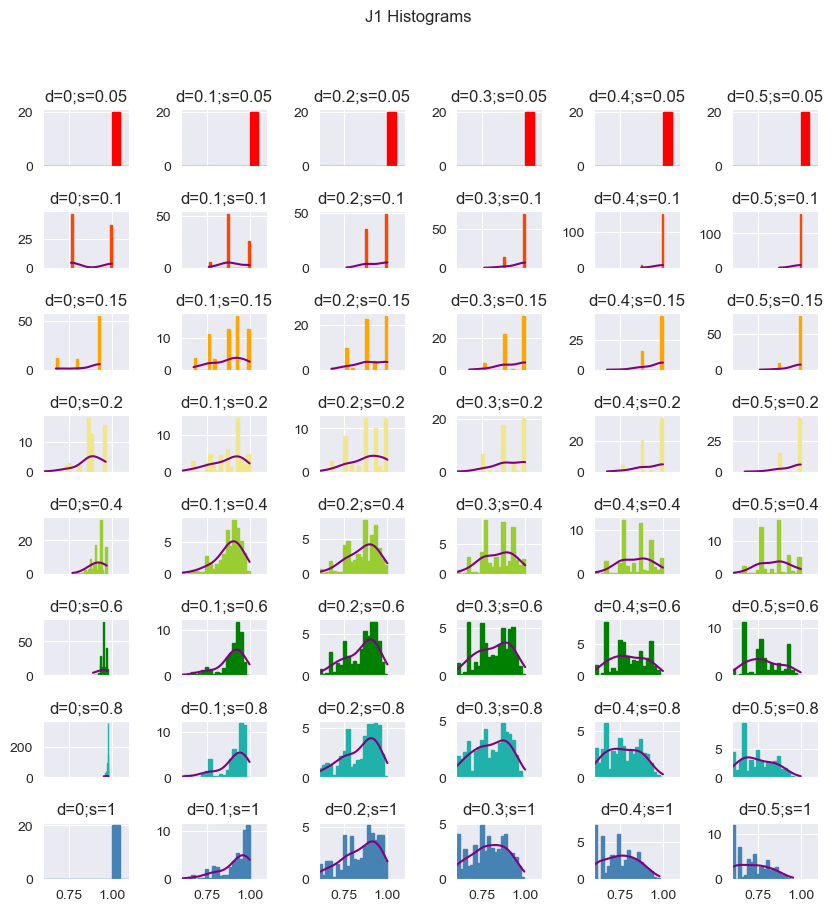

In [11]:
fig, axs = plt.subplots(8,6, sharex=True, figsize=(10,10))

plt.subplots_adjust(wspace = 0.6, hspace = 0.8)

colourList = ['red', 'orangered', 'orange', 'khaki', 'yellowgreen', 'green', 'lightseagreen', 'steelblue']
J1models = pd.DataFrame([
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object)], index = ["0.05", "0.1", "0.15", "0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
for i in [0,1,2,3,4,5]:
    subset = histData.loc[histData['death rate'] == deathRange[i]]
    for j in range(8):
        J1data = subset.loc[subset['proportion'] == proportions[j], ['J1']]
        npJ1 = J1data.to_numpy()
        gakde = KernelDensity(kernel="gaussian", bandwidth=0.05).fit(npJ1)
        xvals = np.linspace(np.min(npJ1), np.max(npJ1), 1000)
        yvals = np.exp(gakde.score_samples(xvals[:, np.newaxis]))
        axs[j,i].hist(J1data, bins = 20, density = True, color = colourList[j], edgecolor = colourList[j], linewidth = None)
        axs[j,i].plot(xvals,yvals, color = 'purple')
        axs[j,i].set_title("d="+str(deathRange[i])+';s='+str(proportions[j]))
        axs[j,i].set_xlim([0.6,1.1])
        J1models.iat[j,i] = gakde

fig.suptitle("J1 Histograms")
plt.savefig('J1 histograms_v0703.png', bbox_inches='tight')
plt.show()

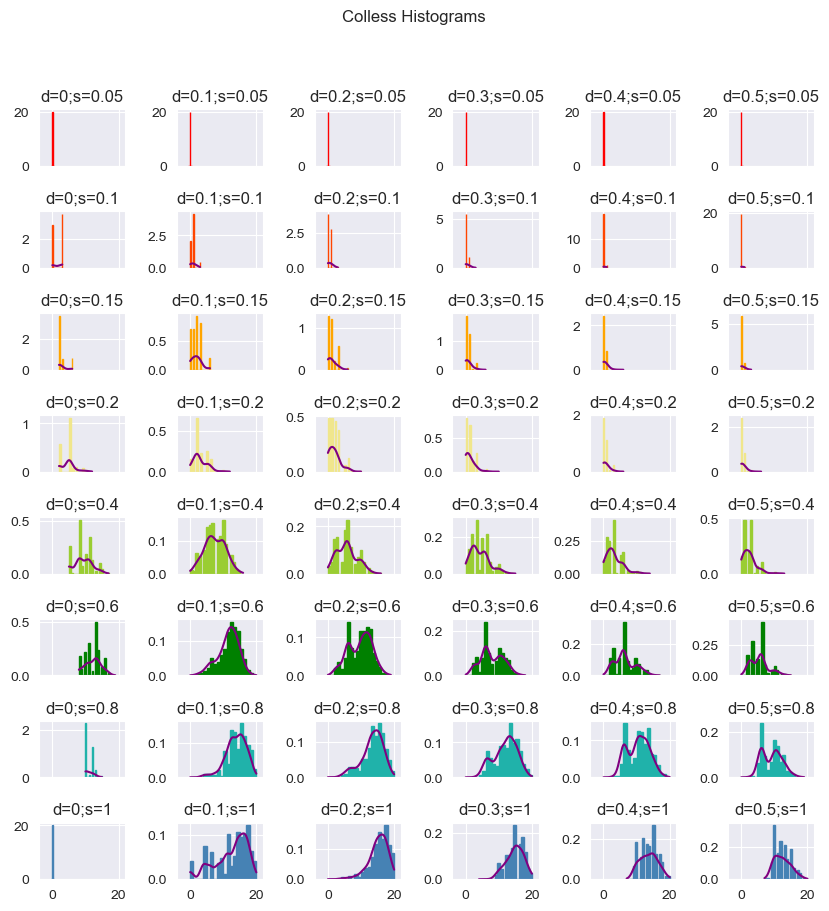

In [12]:
fig, axs = plt.subplots(8,6, sharex=True, figsize = (10,10))
plt.subplots_adjust(wspace = 0.6, hspace = 0.8)

Colmodels = pd.DataFrame([
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object)], index = ["0.05", "0.1", "0.15", "0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
for i in [0,1,2,3,4,5]:
    subset = histData.loc[histData['death rate'] == deathRange[i]]
    for j in range(8):
        Coldata = subset.loc[subset['proportion'] == proportions[j], ['Colless']]
        npCol = Coldata.to_numpy()
        gakde = KernelDensity(kernel="gaussian", bandwidth=1).fit(npCol)
        xvals = np.linspace(np.min(npCol), np.max(npCol), 1000)
        yvals = np.exp(gakde.score_samples(xvals[:, np.newaxis]))
        axs[j,i].hist(Coldata, bins = 20, density = True, color = colourList[j], edgecolor = colourList[j], linewidth = None)
        axs[j,i].plot(xvals, yvals, color = 'purple')
        axs[j,i].set_title("d="+str(deathRange[i])+';s='+str(proportions[j]))
        axs[j,i].set_xlim([-4,22])
        Colmodels.iat[j,i] = gakde

fig.suptitle("Colless Histograms")
plt.savefig('Colless histograms_v0703.png', bbox_inches='tight')
plt.show()

#### Logit Transformation of J1

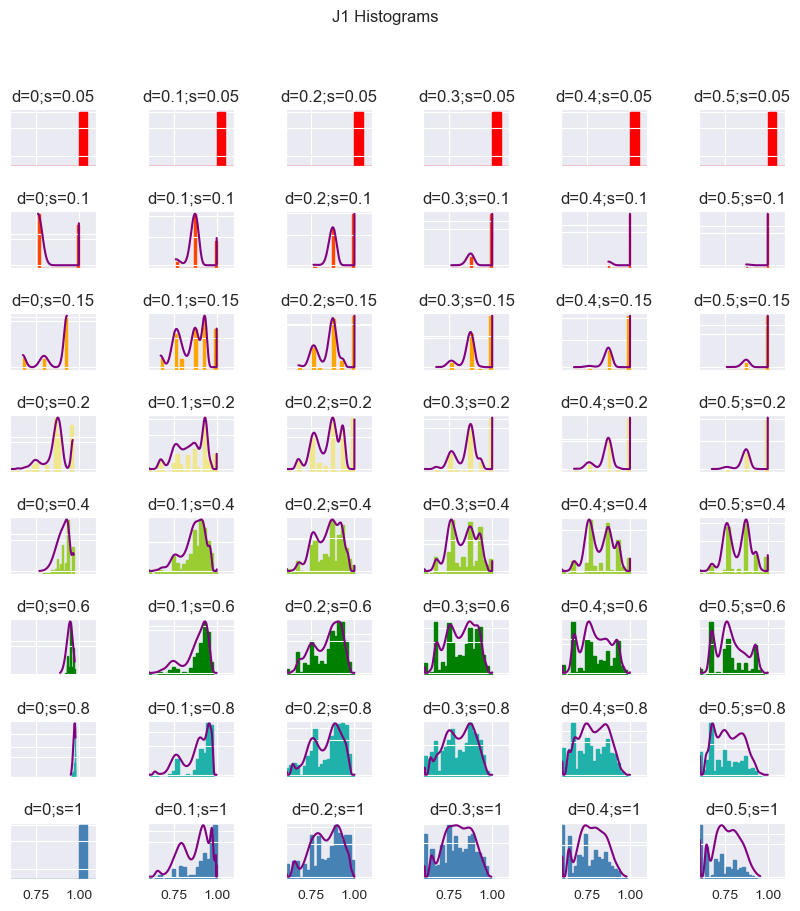

In [13]:
def custom_logit(x, lower_bound, upper_bound):
    x = np.clip(x, lower_bound + 1e-15, upper_bound - 1e-15)
    scaled_x = (x - lower_bound) / (upper_bound - lower_bound)
    return np.log(scaled_x / (1 - scaled_x))

def custom_inverse_logit(y, lower_bound, upper_bound):
    exp_y = np.exp(y)
    scaled_x = exp_y / (1 + exp_y)
    return lower_bound + scaled_x * (upper_bound - lower_bound)

fig, axs = plt.subplots(8,6, sharex=True, figsize=(10,10))

plt.subplots_adjust(wspace = 0.6, hspace = 0.8)

colourList = ['red', 'orangered', 'orange', 'khaki', 'yellowgreen', 'green', 'lightseagreen', 'steelblue']
J1transmodels = pd.DataFrame([
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object)], index = ["0.05", "0.1", "0.15", "0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
for i in [0,1,2,3,4,5]:
    subset = histData.loc[histData['death rate'] == deathRange[i]]
    for j in range(8):
        J1data = subset.loc[subset['proportion'] == proportions[j], ['J1']]
        npJ1 = J1data.to_numpy()
        gakde = KernelDensity(kernel="gaussian", bandwidth=0.25).fit(custom_logit(npJ1, 0.6, 1))
        xvals = np.linspace(np.min(npJ1), np.max(npJ1), 1000)
        logx = custom_logit(xvals, 0.6, 1)
        yvals = custom_inverse_logit(np.exp(gakde.score_samples(logx[:, np.newaxis])), 0.6,1)
        axs[j,i].hist(J1data, bins = 20, density = True, color = colourList[j], edgecolor = colourList[j], linewidth = None)
        ax2 = axs[j,i].twinx()
        ax2.plot(xvals,yvals, color = 'purple')
        axs[j,i].set_title("d="+str(deathRange[i])+';s='+str(proportions[j]))
        axs[j,i].set_xlim([0.6,1.1])
        axs[j,i].tick_params(left = False, labelleft = False)
        ax2.tick_params(right = False, labelright = False)
        J1transmodels.iat[j,i] = gakde

fig.suptitle("J1 Histograms")
plt.savefig('trans J1 histograms.png', bbox_inches='tight')
plt.show()

#### Clipped J1 Kernel Density Estimates (seaborn kdeplot and scipy interpolate)

C:\Users\dhrit\anaconda3\envs\Python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dhrit\anaconda3\envs\Python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dhrit\anaconda3\envs\Python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\dhrit\anaconda3\envs\Python\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

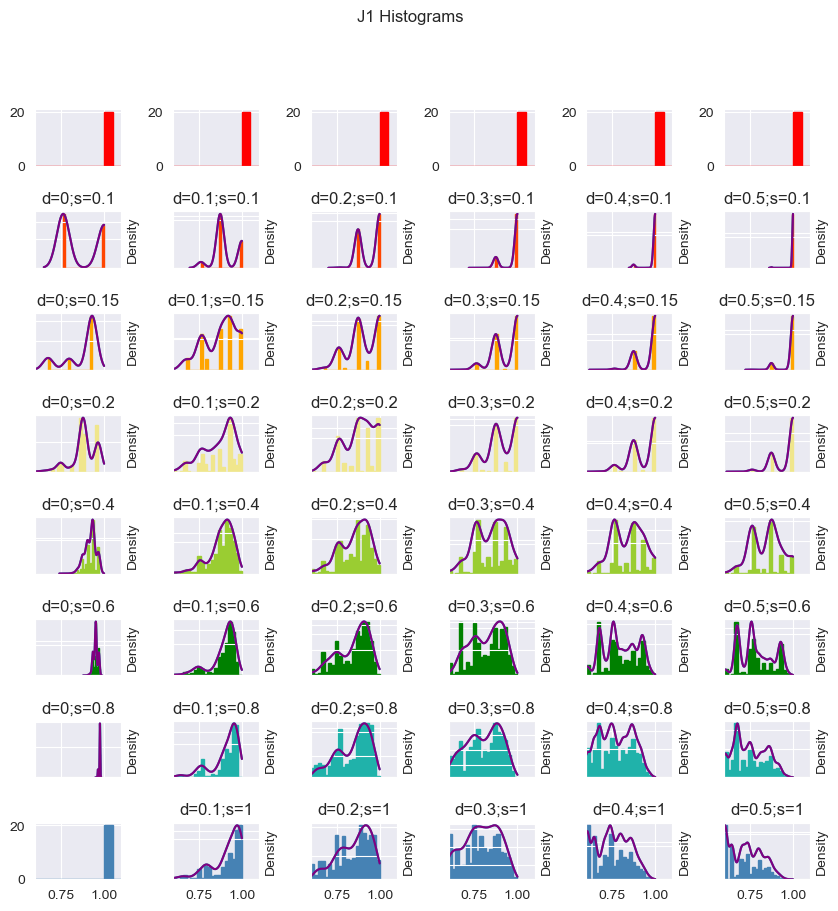

In [14]:
fig, axs = plt.subplots(8,6, sharex=True, figsize=(10,10))

plt.subplots_adjust(wspace = 0.6, hspace = 0.8)


clipJ1models = pd.DataFrame([
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object),
    np.empty(6, dtype=object)], index = ["0.05", "0.1", "0.15", "0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
for i in [0,1,2,3,4,5]:
    subset = histData.loc[histData['death rate'] == deathRange[i]]
    for j in range(8):
        J1data = subset.loc[subset['proportion'] == proportions[j], ['J1']]
        npJ1 = J1data.to_numpy()
        axs[j,i].hist(J1data, bins = 20, density = True, color = colourList[j], edgecolor = colourList[j], linewidth = None)
        if np.var(npJ1) == 0:
            continue
        else:
            ax2 = axs[j,i].twinx()
            if deathRange[i] >0.3 and proportions[j] > 0.4:
                ax2 = sns.kdeplot(npJ1, clip = (0.6,1), color = 'red', bw_adjust =1, legend = False, label = 'kde', warn_singular=False)
            else:
                ax2 = sns.kdeplot(npJ1, clip = (0.6,1), color = 'red', bw_adjust =2, legend = False, label = 'kde', warn_singular=False)
            kde_line = ax2.lines[0]
            kde_x, kde_y = kde_line.get_xdata(), kde_line.get_ydata()
            interp_pdf = interp1d(kde_x, kde_y, kind='linear')
            x_values = np.linspace(min(kde_x), max(kde_x), 1000)
            ax2.plot(x_values, interp_pdf(x_values), color='purple', label='PDF')
            axs[j,i].set_title("d="+str(deathRange[i])+';s='+str(proportions[j]))
            axs[j,i].set_xlim([0.6,1.1])
            axs[j,i].tick_params(left = False, labelleft = False)
            ax2.tick_params(right = False, labelright = False)
            clipJ1models.iat[j,i] = interp_pdf

fig.suptitle("J1 Histograms")
plt.savefig('J1 histograms_v1103_clip.png', bbox_inches='tight')
plt.show()

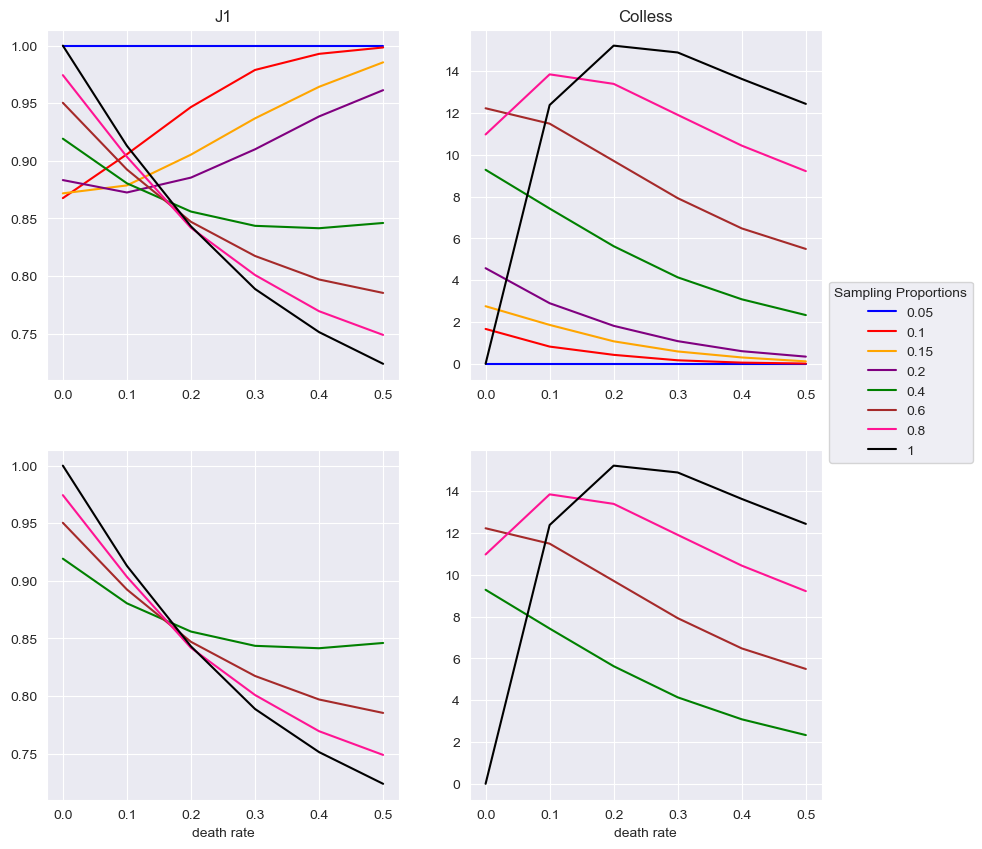

In [15]:
fig,axs = plt.subplots(2,2, figsize = (10,10))
colours = ['blue', 'red', 'orange', 'purple', 'green', 'brown', 'deeppink', 'black']
for i in [4,5,6,7]:
    subset = histData.loc[histData['proportion'] == proportions[i]]
    meanJ1 = []
    meanCol = []
    for j in deathRange:
        J1sub =  subset.loc[subset['death rate'] == j, ['J1']].to_numpy()
        Colsub =  subset.loc[subset['death rate'] == j, ['Colless']].to_numpy()
        meanJ1.append(np.mean(J1sub))
        meanCol.append(np.mean(Colsub))
    axs[1,0].plot(deathRange, meanJ1, color = colours[i], label = str(proportions[i]))
    axs[1,1].plot(deathRange, meanCol, color = colours[i], label = str(proportions[i]))


for i in range(8):
    subset = histData.loc[histData['proportion'] == proportions[i]]
    meanJ1 = []
    meanCol = []
    for j in deathRange:
        J1sub =  subset.loc[subset['death rate'] == j, ['J1']].to_numpy()
        Colsub =  subset.loc[subset['death rate'] == j, ['Colless']].to_numpy()
        meanJ1.append(np.mean(J1sub))
        meanCol.append(np.mean(Colsub))
    axs[0,0].plot(deathRange, meanJ1, color = colours[i], label = str(proportions[i]))
    axs[0,1].plot(deathRange, meanCol, color = colours[i], label = str(proportions[i]))




handles, labels = axs[0,1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')

axs[0,0].set_title('J1')
axs[0,1].set_title('Colless')
axs[1,0].set_xlabel('death rate')
axs[1,1].set_xlabel('death rate')
plt.legend(handles, labels, title = "Sampling Proportions", loc='upper left', bbox_to_anchor=(1,1.5))
plt.savefig('mean index for death rate by sampling proportion.png', bbox_inches='tight')

plt.show()

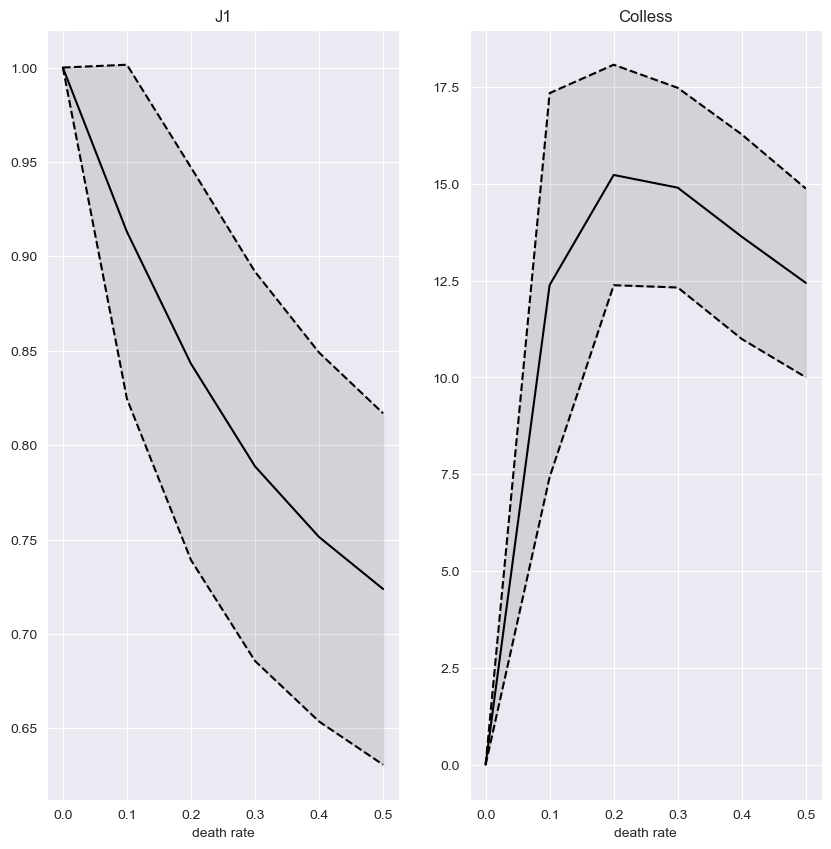

In [16]:
fig,axs = plt.subplots(1,2, figsize = (10,10))
subset = histData.loc[histData['proportion'] == 1]
meanJ1 = []
stdJ1 = []
stdCol = []
meanCol = []
for j in deathRange:
    J1sub =  subset.loc[subset['death rate'] == j, ['J1']].to_numpy()
    Colsub =  subset.loc[subset['death rate'] == j, ['Colless']].to_numpy()
    meanJ1.append(np.mean(J1sub))
    stdJ1.append(np.std(J1sub))
    meanCol.append(np.mean(Colsub))
    stdCol.append(np.std(Colsub))
meanJ1 = np.array(meanJ1)
meanCol = np.array(meanCol)
stdJ1 = np.array(stdJ1)
stdCol = np.array(stdCol)
axs[0].plot(deathRange, meanJ1, color = 'black', label = '1')
axs[0].fill_between(deathRange, meanJ1+stdJ1, meanJ1-stdJ1, alpha = 0.1, color = 'black')
axs[0].plot(deathRange, meanJ1+stdJ1, color = 'black', label = '1',linestyle = 'dashed')
axs[0].plot(deathRange, meanJ1-stdJ1, color = 'black', label = '1',linestyle = 'dashed')
axs[1].plot(deathRange, meanCol, color = 'black', label = '1')
axs[1].fill_between(deathRange, meanCol+stdCol, meanCol-stdCol, alpha = 0.1, color = 'black')
axs[1].plot(deathRange, meanCol+stdCol, color = 'black', label = '1',linestyle = 'dashed')
axs[1].plot(deathRange, meanCol-stdCol, color = 'black', label = '1',linestyle = 'dashed')
meanJ1.tolist()
meanCol.tolist()
stdJ1.tolist()
stdCol.tolist()


axs[0].set_title('J1')
axs[1].set_title('Colless')
axs[0].set_xlabel('death rate')
axs[1].set_xlabel('death rate')
plt.savefig('whole trees.png', bbox_inches='tight')

plt.show()

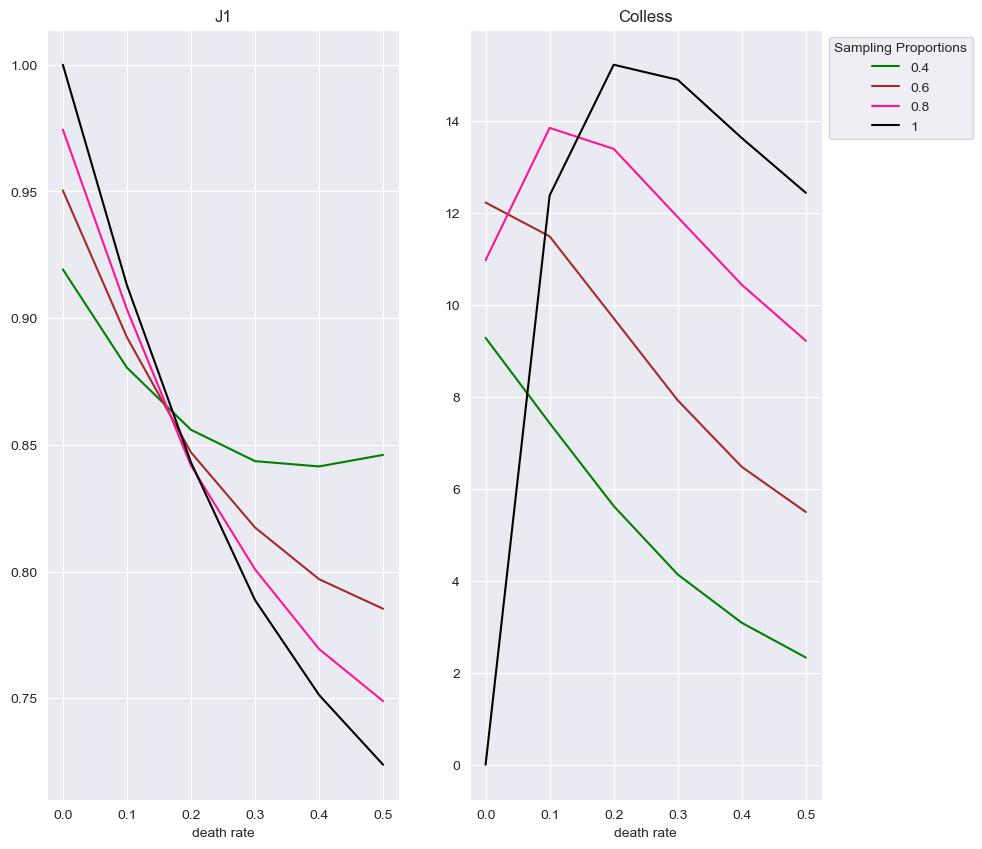

In [17]:
fig,axs = plt.subplots(1,2, figsize = (10,10))
colours = ['blue', 'red', 'orange', 'purple', 'green', 'brown', 'deeppink', 'black']
for i in [4,5,6,7]:
    subset = histData.loc[histData['proportion'] == proportions[i]]
    meanJ1 = []
    meanCol = []
    for j in deathRange:
        J1sub =  subset.loc[subset['death rate'] == j, ['J1']].to_numpy()
        Colsub =  subset.loc[subset['death rate'] == j, ['Colless']].to_numpy()
        meanJ1.append(np.mean(J1sub))
        meanCol.append(np.mean(Colsub))
    axs[0].plot(deathRange, meanJ1, color = colours[i], label = str(proportions[i]))
    axs[1].plot(deathRange, meanCol, color = colours[i], label = str(proportions[i]))


handles, labels = axs[1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')

axs[0].set_title('J1')
axs[1].set_title('Colless')
axs[0].set_xlabel('death rate')
axs[1].set_xlabel('death rate')
plt.legend(handles, labels, title = "Sampling Proportions", loc='upper left', bbox_to_anchor=(1,1))
plt.savefig('proportion over 40.png', bbox_inches='tight')

plt.show()

### Inference
#### Simulated data

In [21]:
testD = np.random.choice(deathRange, 10, replace = True)
testS = np.random.choice(proportions, 10, replace = True)
testRates = []
testSamples = []
testJ = []
testC = []
for i in range(10):
    args.pdeath = testD[i]
    tree = nx.DiGraph()
    tree = simpleModel('S', args.start_day, args.start_reps, '0', tree)
    if (len(tree.nodes) == 0) or (max(nx.shortest_path_length(tree, source = '0').values())!=5):
        continue
    else:
        eteTree = nw_to_ete3('0', tree)
        leafList = eteTree.get_leaves()
        leaves = [str(k.name) for k in leafList]
        p = math.ceil(testS[i]*len(leaves))
        if p <2:
            continue
        else:
            sampleLeaves = np.random.choice(leaves, p, replace = False).tolist()
            copy = nw_to_ete3('0', tree)
            copy.prune(sampleLeaves)
            prunedTree = ete3_to_nx(copy)
            testRates.append(testD[i])
            testSamples.append(testS[i])
            testC.append(colless(tree))
            testJ.append(J1(tree))

testData = pd.DataFrame(
    {"death rate": testRates,
     "proportion": testSamples,
     "Colless": testC,
     "J1": testJ
     }
)
display(testData)
for i in range(len(testData)):
    J1scores = pd.DataFrame([
        np.zeros(6),
        np.zeros(6),
        np.zeros(6),
        np.zeros(6),
        np.zeros(6)], index = ["0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
    Colscores = pd.DataFrame([
        np.zeros(6),
        np.zeros(6),
        np.zeros(6),
        np.zeros(6),
        np.zeros(6)], index = ["0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
    for j in J1scores.index.values.tolist():
        for k in J1scores.columns.values.tolist():
            Colscores.at[j, k] = np.exp(Colmodels.at[j,k].score_samples(testData.loc[i, 'Colless'].reshape(-1,1)))
            if isinstance(clipJ1models.at[j,k], KernelDensity):
                J1scores.at[j, k] = np.exp(clipJ1models.at[j,k].score_samples(testData.loc[i, 'J1'].reshape(1, -1)))
            elif isinstance(clipJ1models.at[j,k], interp1d):
                if clipJ1models.at[j,k].x[0] > testData.loc[i, 'J1']:
                    continue
                else:
                    J1scores.at[j, k] = clipJ1models.at[j,k](testData.loc[i, 'J1'])
    print("Actual values: d = ", testData.loc[i, 'death rate'], " , s = ", testData.loc[i, 'proportion'])
    print("The most likely combinations of (s, d) predicted by the J1 model are: ",J1scores.stack().sort_values(ascending = False).index.values.tolist()[0:3])
    print("The most likely combinations of (s, d) predicted by the Colless model are: ",Colscores.stack().sort_values(ascending = False).index.values.tolist()[0:3])
    print('\n')

,death rate,proportion,Colless,J1
0,0.4,0.80,14,0.799261
1,0.3,0.15,16,0.865828
2,0.4,0.80,12,0.600107
3,0.4,0.20,15,0.648232
4,0.2,0.80,18,0.758529
5,0.3,0.80,16,0.902792


Actual values: d =  0.4  , s =  0.8
The most likely combinations of (s, d) predicted by the J1 model are:  [('1', '0.4'), ('1', '0.5'), ('1', '0.3')]
The most likely combinations of (s, d) predicted by the Colless model are:  [('0.6', '0'), ('0.8', '0.2'), ('1', '0.4')]


Actual values: d =  0.3  , s =  0.15
The most likely combinations of (s, d) predicted by the J1 model are:  [('0.2', '0'), ('0.2', '0.4'), ('0.4', '0.1')]
The most likely combinations of (s, d) predicted by the Colless model are:  [('1', '0.2'), ('1', '0.3'), ('0.8', '0.1')]


Actual values: d =  0.4  , s =  0.8
The most likely combinations of (s, d) predicted by the J1 model are:  [('1', '0.5'), ('1', '0.4'), ('0.8', '0.5')]
The most likely combinations of (s, d) predicted by the Colless model are:  [('0.8', '0'), ('0.6', '0.1'), ('1', '0.5')]


Actual values: d =  0.4  , s =  0.2
The most likely combinations of (s, d) predicted by the J1 model are:  [('1', '0.5'), ('1', '0.4'), ('0.8', '0.5')]
The most likely combin

#### Sanger data

In [ ]:
def sanger_to_nx(eteTree):
    nxTree = nx.DiGraph()
    root = eteTree.get_tree_root()
    dummyName = '0'
    if root.name == '':
        nxTree.add_node(dummyName)
        dummyName = dummyName + '0'
    else:
        nxTree.add_node(root.name)
    for node in eteTree.traverse("levelorder"):
        if node.name == '':
            node.name = dummyName
            dummyName = dummyName + '0'
        if len(node.children) == 0:
            continue
        else:
            for j in node.children:
                if j.name =='' :
                    j.name = dummyName
                    dummyName = dummyName + '0'
                nxTree.add_edge(node.name, j.name)
    return nxTree

pd28690 = sanger_to_nx(Tree("sanger data//PD28690_snv_tree_2021_final.tree"))
pd43850 = sanger_to_nx(Tree("sanger data//PD43850.snv_tree_with_branch_length.tree"))
pd43851 = sanger_to_nx(Tree("sanger data//PD43851.snv_tree_with_branch_length.tree"))

sangerJ1 = np.array([J1(pd28690), J1(pd43850), J1(pd43851)])
sangerCol = np.array([colless(pd28690), colless(pd43850), colless(pd43851)])
sangerNames = np.array(['pd28690', 'pd43850', 'pd43851'])
sangerLengths = np.array([max(nx.shortest_path_length(pd28690, source = '00').values()), max(nx.shortest_path_length(pd43850, source = '00').values()), max(nx.shortest_path_length(pd43851, source = '00').values())])
sangerData = pd.DataFrame({
    "name": sangerNames,
    "J1": sangerJ1,
    "Colless": sangerCol,
    'branches': sangerLengths
})
display(sangerData)

In [ ]:
fig,axs = plt.subplots(figsize = (10,10))
colours = ['blue', 'red', 'orange', 'purple', 'green', 'brown', 'deeppink', 'black']
colourSample = ['sandybrown', 'chocolate', 'saddlebrown']
for i in [4,5,6,7]:
    subset = histData.loc[histData['proportion'] == proportions[i]]
    meanJ1 = []
    for j in deathRange:
        J1sub =  subset.loc[subset['death rate'] == j, ['J1']].to_numpy()
        meanJ1.append(np.mean(J1sub))
    axs.plot(deathRange, meanJ1, color = colours[i], label = str(proportions[i]))
for i in range(len(sangerData)):
    axs.axhline(y = sangerData.at[i, "J1"], color = colourSample[i], label = sangerData.at[i, "name"], linestyle = '--')

handles, labels = axs.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')


axs.set_title('J1')
axs.set_xlabel('death rate')
plt.legend(handles, labels, title = "Legend", loc='upper left', bbox_to_anchor=(1,1))
plt.savefig('sanger plot.png', bbox_inches='tight')

plt.show()

In [ ]:
#considering only the first 5 generations, creating trees that are the same say as in the simulations
pd28690trunc = dfs_tree(pd28690, '00', 5)
pd43850trunc = dfs_tree(pd43850, '00', 5)
pd43851trunc = dfs_tree(pd43851, '00', 5)
sangerJ1 = np.array([J1(pd28690trunc), J1(pd43850trunc), J1(pd43851trunc)])
sangerCol = np.array([colless(pd28690trunc), colless(pd43850trunc), colless(pd43851trunc)])
sangerNames = np.array(['pd28690', 'pd43850', 'pd43851'])
sangerLengths = np.array([max(nx.shortest_path_length(pd28690trunc, source = '00').values()), max(nx.shortest_path_length(pd43850trunc, source = '00').values()), max(nx.shortest_path_length(pd43851trunc, source = '00').values())])
truncsangerData = pd.DataFrame({
    "name": sangerNames,
    "J1": sangerJ1,
    "Colless": sangerCol,
    'branches': sangerLengths
})
display(truncsangerData)

In [ ]:
for i in range(len(truncsangerData)):
    J1scores = pd.DataFrame([
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6)], index = ["0.05", "0.1", "0.15", "0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
    Colscores = pd.DataFrame([
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6),
    np.zeros(6)], index = ["0.05", "0.1", "0.15", "0.2", "0.4", "0.6", "0.8", "1"], columns = ["0", "0.1", "0.2", "0.3", "0.4", "0.5"])
    jval = truncsangerData.at[i, "J1"]
    cval = truncsangerData.at[i, "Colless"]
    for j in J1scores.index.values.tolist():
        for k in J1scores.columns.values.tolist():
            Colscores.at[j, k] = np.exp(Colmodels.at[j,k].score_samples(np.array(cval).reshape(-1,1)))
            if isinstance(clipJ1models.at[j,k], KernelDensity):
                J1scores.at[j, k] = np.exp(clipJ1models.at[j,k].score_samples(np.array([jval]).reshape(1, -1)))
            elif isinstance(clipJ1models.at[j,k], interp1d):
                if clipJ1models.at[j,k].x[0] > jval:
                    continue
                J1scores.at[j, k] = clipJ1models.at[j,k](jval)
    print("For tree ", truncsangerData.at[i, "name"], "with J1 = ", truncsangerData.at[i, "J1"].round(2), "and Colless =  ", truncsangerData.at[i, "Colless"])
    print("The most likely combinations of (s, d) predicted by the J1 model are: ",J1scores.stack().sort_values(ascending = False).index.values.tolist()[0:3])
    print("The most likely combinations of (s, d) predicted by the Colless model are: ",Colscores.stack().sort_values(ascending = False).index.values.tolist()[0:3])
    print('\n')

In [ ]:
fig,axs = plt.subplots(1,2, figsize = (10,10))
colours = ['blue', 'red', 'orange', 'purple', 'green', 'brown', 'deeppink', 'black']
for i in [0,1,2,3,4,5,6,7]:
    subset = histData.loc[histData['proportion'] == proportions[i]]
    meanJ1 = []
    meanCol = []
    for j in deathRange:
        J1sub =  subset.loc[subset['death rate'] == j, ['J1']].to_numpy()
        Colsub =  subset.loc[subset['death rate'] == j, ['Colless']].to_numpy()
        meanJ1.append(np.mean(J1sub))
        meanCol.append(np.mean(Colsub))
    axs[0].plot(deathRange, meanJ1, color = colours[i], label = str(proportions[i]))
    axs[1].plot(deathRange, meanCol, color = colours[i], label = str(proportions[i]))

for i in range(len(truncsangerData)):
    axs[0].axhline(y = truncsangerData.at[i, "J1"], color = colourSample[i], label = truncsangerData.at[i, "name"], linestyle = '--')
    axs[1].axhline(y = truncsangerData.at[i, "Colless"], color = colourSample[i], label = truncsangerData.at[i, "name"], linestyle = '--')

handles, labels = axs[1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')


axs[1].set_ylim((0,17))
axs[0].set_title('J1')
axs[1].set_title('Colless')
axs[0].set_xlabel('death rate')
axs[1].set_xlabel('death rate')
plt.legend(handles, labels, title = "Legend", loc='upper left', bbox_to_anchor=(1,1))
plt.savefig('sanger plots truncated all p.png', bbox_inches='tight')

plt.show()